## Import Libraries

In [93]:
# Data Analysis
import pandas as pd          # data analysis library for handling structured data
from pandas import DataFrame d
import numpy as np           # mathematical library for working with numerical data
from pandas.plotting import parallel_coordinates 
from statsmodels.tsa.seasonal import seasonal_decompose # library for performing statistical analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from typing import List
import pickle

# Visualization
import matplotlib.pyplot as plt     # data visualization library for creating graphs and charts
%matplotlib inline
import seaborn as sns        # data visualization library based on matplotlib for creating more attractive visualizations
import plotly.io as pio
import plotly.express as px   # interactive data visualization library
import plotly.graph_objects as go   # library for creating interactive graphs and charts
import matplotlib 
import kaleido 
import pickle 

# Machine Learning 
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from prophet import Prophet
from xgboost import XGBRegressor 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore") 

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Case Study

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia

This dataset contains over 10 years of hourly energy consumption data from PJM in Megawatts

This notebook will go through the model solution for univariate time series. There are endless models out there when it comes to time series, one of the most popular methods is Prophet developed by Facebook/Meta. So, we will take a look later at building models section. This time, not only that. we will use with 5 different approaches to see which one has the best performance

## Load Data

In [94]:
aep = pd.read_csv('Dataset/AEP_hourly.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)
comed = pd.read_csv('Dataset/COMED_hourly.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)
dayton = pd.read_csv('Dataset/DAYTON_hourly.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)
deok = pd.read_csv('Dataset/DEOK_hourly.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)
dom = pd.read_csv('Dataset/DOM_hourly.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)
duq = pd.read_csv('Dataset/DUQ_hourly.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)
ekpc = pd.read_csv('Dataset/EKPC_hourly.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)
fe = pd.read_csv('Dataset/FE_hourly.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)
ni = pd.read_csv('Dataset/NI_hourly.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)
pjm_hourly = pd.read_csv('Dataset/pjm_hourly_est.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)
pjm_load = pd.read_csv('Dataset/PJM_Load_hourly.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)
pjme = pd.read_csv('Dataset/PJME_hourly.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)
pjmw = pd.read_csv('Dataset/PJMW_hourly.csv', index_col='Datetime', parse_dates = ["Datetime"], infer_datetime_format= True)


## Basic Preprocessing 

In [95]:
result_2 = aep.join([comed, dayton, deok, dom, duq, ekpc, fe, ni, pjm_hourly, pjm_load, pjme, pjmw], how='outer')
# result_2 = aep.join([comed, dayton, deok, dom, duq, ekpc, fe, ni, pjme, pjmw], how='outer') 
result_2 = result_2.reset_index()
result_2["Datetime"] = pd.to_datetime(result_2["Datetime"], infer_datetime_format=True)
result_2.set_index(keys="Datetime", inplace=True) 
result_2.sort_index()
result_2.head(4) 

,AEP_MW,COMED_MW,DAYTON_MW,DEOK_MW,DOM_MW,DUQ_MW,EKPC_MW,FE_MW,NI_MW,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,PJM_Load_MW,PJME_MW,PJMW_MW
Datetime,,,,,,,,,,,,,,,,,,,,,,,,
1998-04-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22259.0,22259.0,NaN,NaN
1998-04-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21244.0,21244.0,NaN,NaN
1998-04-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20651.0,20651.0,NaN,NaN
1998-04-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20421.0,20421.0,NaN,NaN


In [96]:
result_2.describe()

,AEP_MW,COMED_MW,DAYTON_MW,DEOK_MW,DOM_MW,DUQ_MW,EKPC_MW,FE_MW,NI_MW,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,PJM_Load_MW,PJME_MW,PJMW_MW
count,129457.000000,74681.000000,129459.000000,65923.000000,124373.000000,127252.000000,53518.000000,71058.000000,58450.000000,129457.000000,74681.000000,129459.000000,65923.000000,124373.000000,127252.000000,53518.000000,71058.000000,58450.000000,153550.000000,151390.000000,32896.000000,32896.000000,153550.000000,151390.000000
mean,15235.017048,11074.994001,1998.721371,2985.858911,10747.474002,1626.313425,1410.853993,7549.671691,11701.682943,15235.017048,11074.994001,1998.721371,2985.858911,10747.474002,1626.313425,1410.853993,7549.671691,11701.682943,31528.417213,5523.671861,29766.427408,29766.427408,31528.417213,5523.671861
std,2719.606727,2391.462624,410.747819,663.425898,2456.758994,317.494387,384.433003,1423.930663,2371.498701,2719.606727,2391.462624,410.747819,663.425898,2456.758994,317.494387,384.433003,1423.930663,2371.498701,6709.630178,1009.576839,5849.769954,5849.769954,6709.630178,1009.576839
min,9581.000000,7237.000000,982.000000,907.000000,1253.000000,1014.000000,514.000000,0.000000,7003.000000,9581.000000,7237.000000,982.000000,907.000000,1253.000000,1014.000000,514.000000,0.000000,7003.000000,14544.000000,487.000000,17461.000000,17461.000000,14544.000000,487.000000
25%,13190.000000,9197.000000,1684.000000,2525.000000,8966.000000,1401.000000,1112.000000,6399.000000,9954.000000,13190.000000,9197.000000,1684.000000,2525.000000,8966.000000,1401.000000,1112.000000,6399.000000,9954.000000,26742.000000,4758.000000,25473.000000,25473.000000,26742.000000,4758.000000
50%,15098.000000,10881.000000,1979.000000,2931.000000,10309.000000,1605.000000,1343.000000,7508.000000,11521.000000,15098.000000,10881.000000,1979.000000,2931.000000,10309.000000,1605.000000,1343.000000,7508.000000,11521.000000,31056.000000,5458.000000,29655.000000,29655.000000,31056.000000,5458.000000
75%,17045.000000,12289.000000,2256.000000,3368.000000,12204.000000,1803.000000,1635.000000,8415.000000,12896.750000,17045.000000,12289.000000,2256.000000,3368.000000,12204.000000,1803.000000,1635.000000,8415.000000,12896.750000,35329.000000,6200.750000,33073.250000,33073.250000,35329.000000,6200.750000
max,25695.000000,23753.000000,3746.000000,5445.000000,21651.000000,3054.000000,3490.000000,14032.000000,23631.000000,25695.000000,23753.000000,3746.000000,5445.000000,21651.000000,3054.000000,3490.000000,14032.000000,23631.000000,62009.000000,9594.000000,54030.000000,54030.000000,62009.000000,9594.000000


## Exploratory Data Analysis

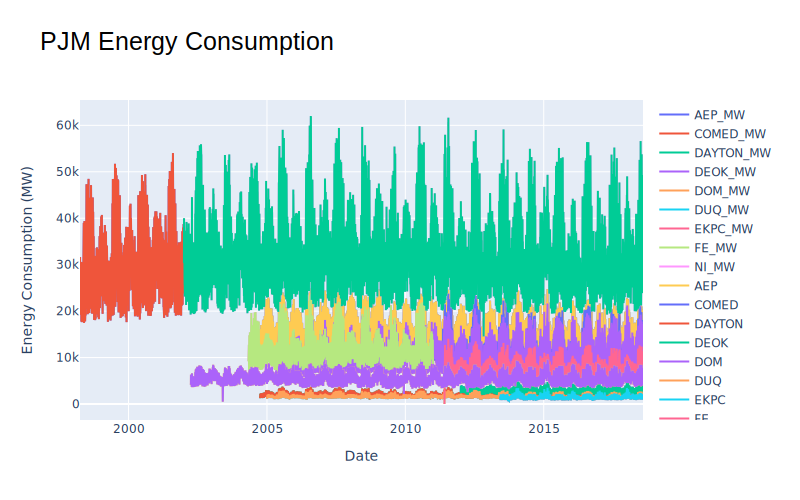

In [97]:
fig = go.Figure(layout=go.Layout(
        height=500,
        width=800,
    ))

for col in result_2.columns:
    fig.add_trace(go.Scatter(x=result_2.index, y=result_2[col], name=col))

fig.update_layout(
    title={
        'text': 'PJM Energy Consumption',
        'font': {'size': 25, 'family': 'Arial', 'color': 'black'}
    },
    xaxis_title='Date',
    yaxis_title='Energy Consumption (MW)'
)

fig.show(renderer='svg') 
# fig.savefig("Images/PJM_Energy_Consumption.png", dpi=300, bbox_inches='tight') 
fig.write_image("Images/PJM_Energy_Consumption.png", width=800, height=500)
# for trace in fig.data:
#     del trace 

From the chart and descriptive information above, it is evident that PJME_MW transmission line generates the highest megawatts of electricity. In addition, the dataset have multiple date ranges.

In [98]:
cols = ['AEP_MW', 'COMED_MW', 'DAYTON_MW', 'DEOK_MW', 'DOM_MW', 'DUQ_MW',
        'EKPC_MW', 'FE_MW', 'NI_MW', 'PJME_MW', 'PJMW_MW']

result_2['Hour'] = result_2.index.hour
result_2['Day'] = result_2.index.day 
result_2['Month'] = result_2.index.month
result_2['Year'] = result_2.index.year  
result_2['Quarter'] = result_2.index.quarter

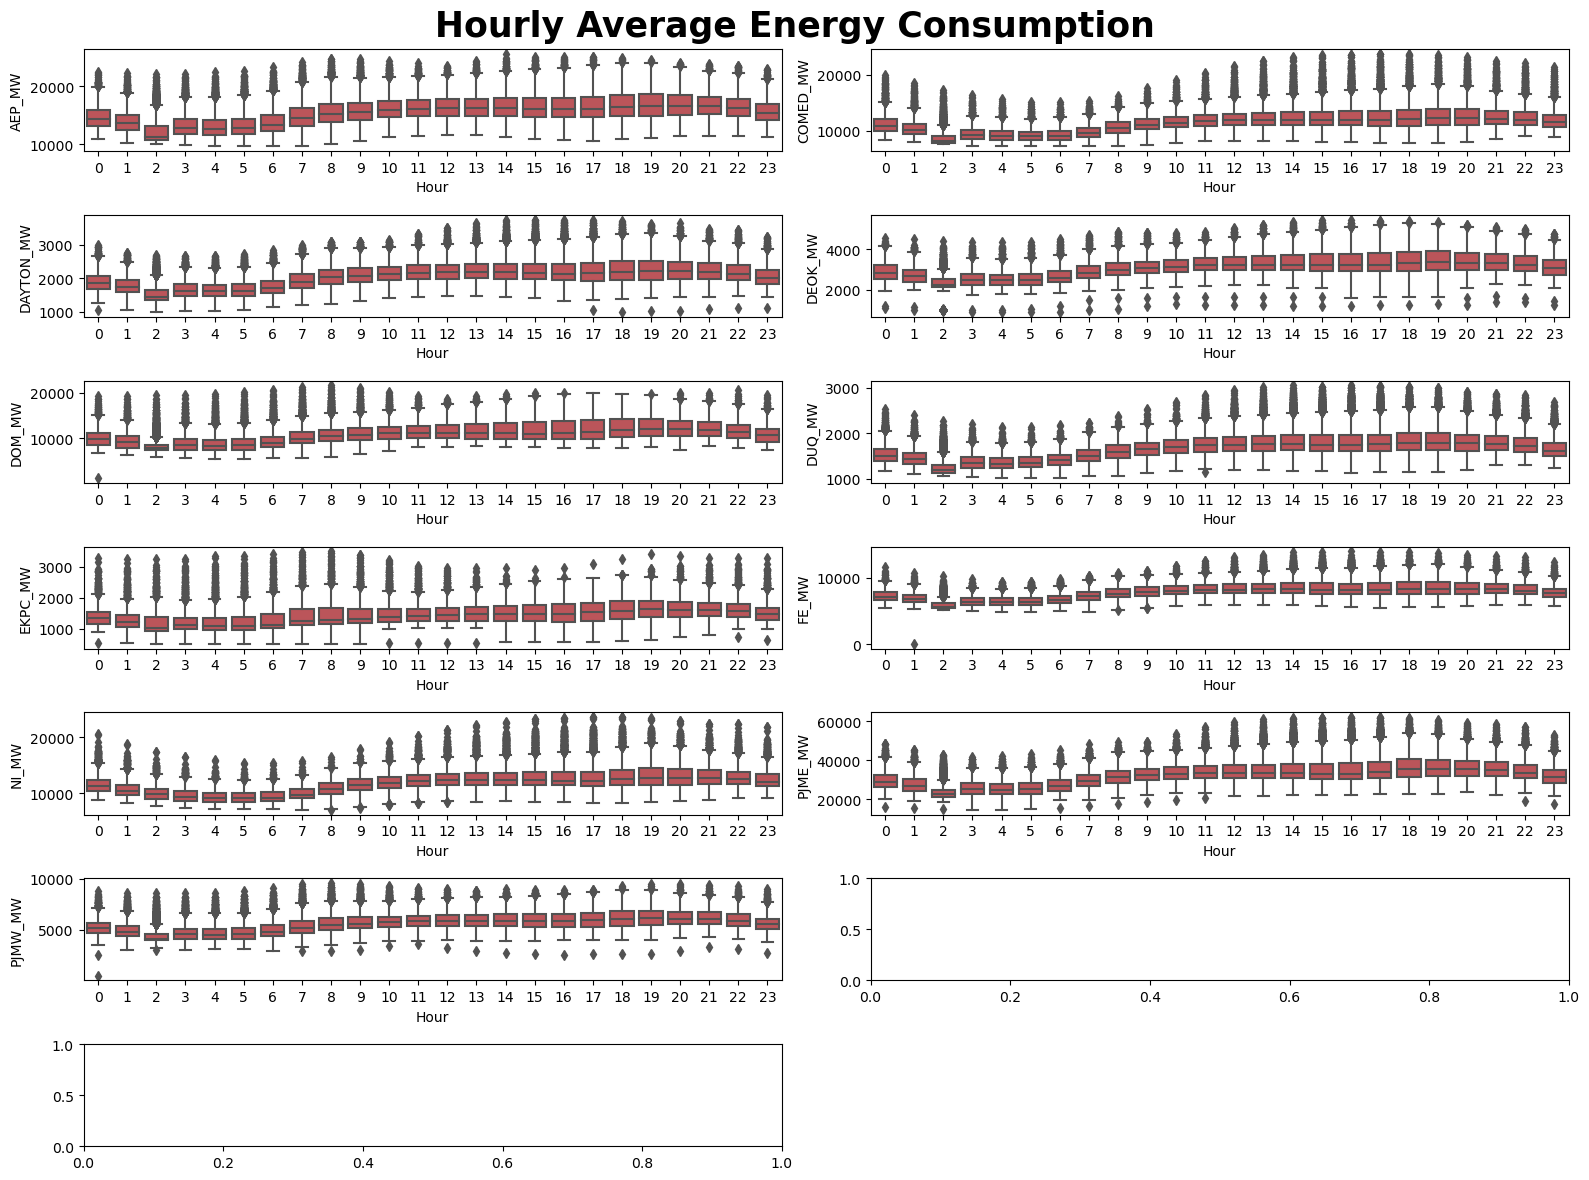

In [99]:
#Hourly Average Energy Consumption 
from typing import List
def visualize_subplots_boxplots(df: DataFrame, columns: List[str], nrows: int, ncols: int, savepath) -> None:
    """
    Creates a grid of subplots containing boxplots of Hourly average energy consumption.

    Args:
        df: A Pandas DataFrame containing energy consumption data.
        columns: A list of column names to include in the boxplots.
        nrows: The number of rows in the subplot grid.
        ncols: The number of columns in the subplot grid.

    Returns:
        None. Displays a grid of subplots containing boxplots of daily average energy consumption.

    Example:
        >>> visualize_subplots_boxplots(my_df, ['Consumption', 'Generation'], 3, 4)
    """
    from typing import List
    from pandas import DataFrame
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))
    fig.suptitle('Hourly Average Energy Consumption', weight='bold', fontsize=25)

    # We just need 11 figures, so we delete the last one
    if nrows*ncols > len(columns):
        fig.delaxes(axes[nrows-1][ncols-1])

    for i, col in enumerate(columns): 
        sns.boxplot(data=df, x='Hour', y=col, ax=axes.flatten()[i], color='#cc444b')

    plt.tight_layout()
    plt.show()
    fig.savefig(savepath, dpi=300, bbox_inches='tight')
visualize_subplots_boxplots(df=result_2, columns= cols, nrows=7, ncols=2, savepath = "Images/Hourly_Average_Energy_Consumption.png")


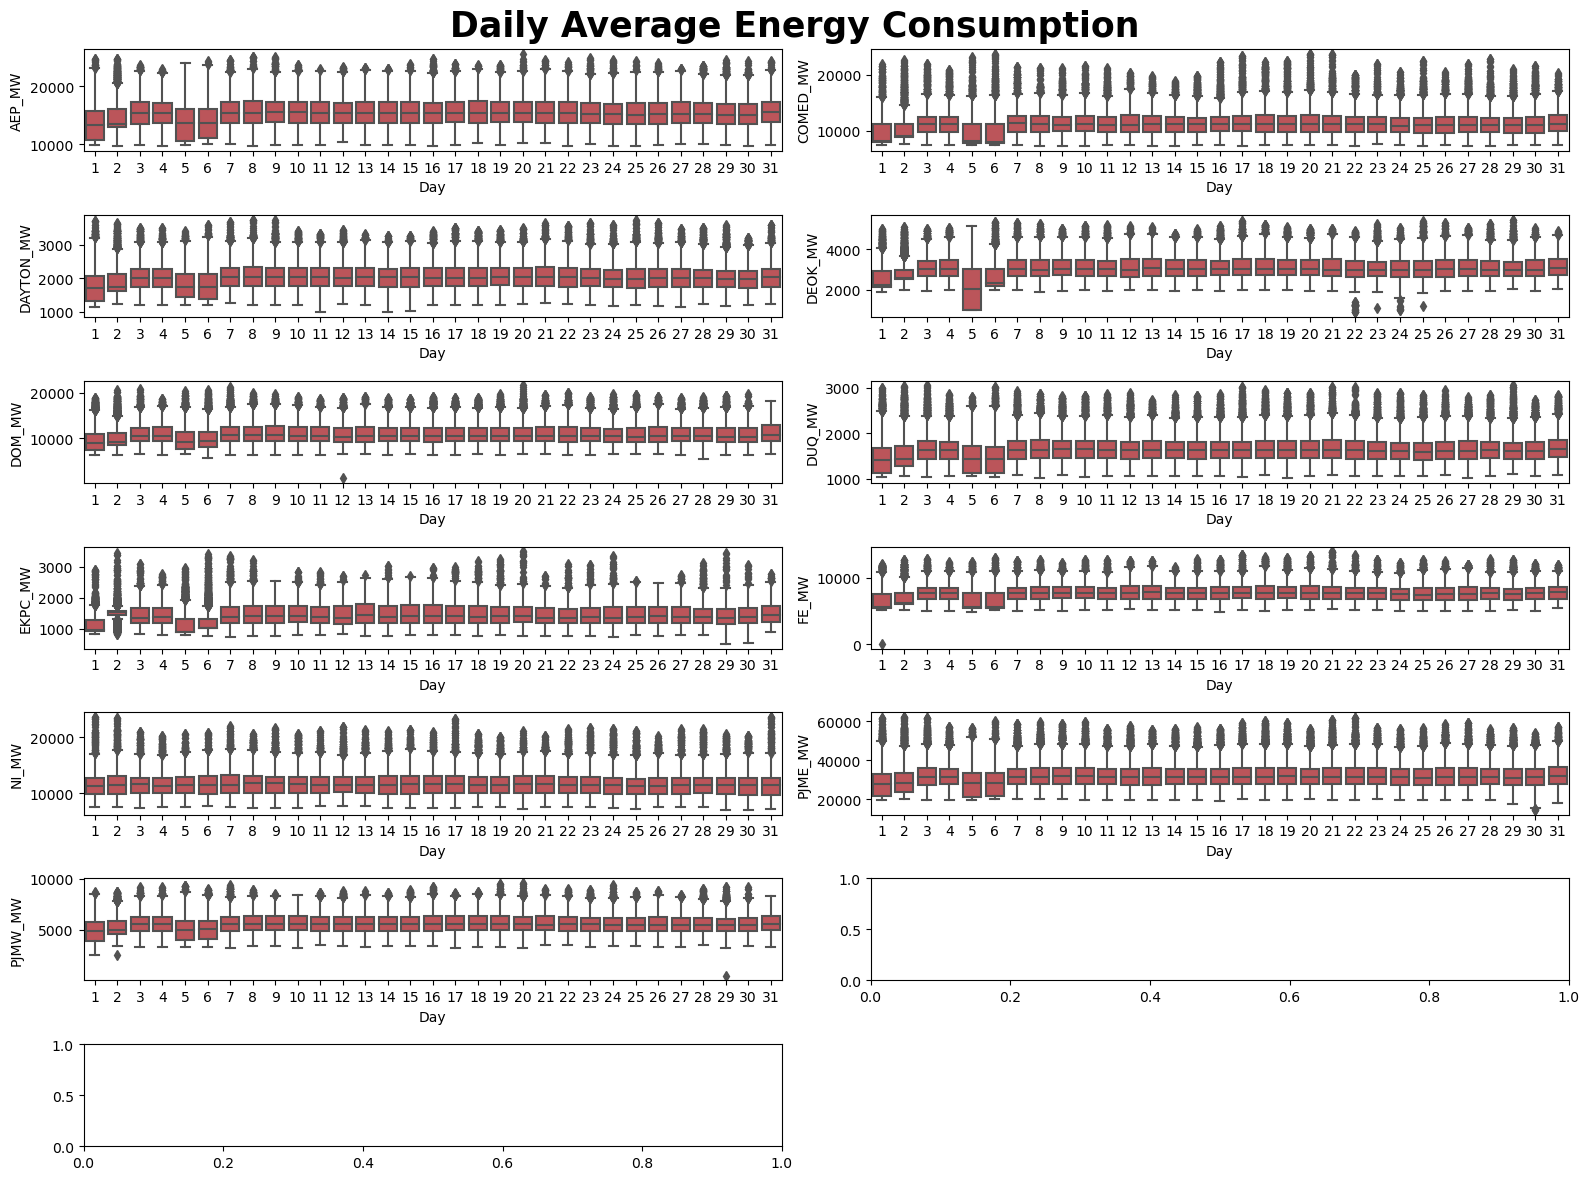

In [100]:
#Daily Average Energy Consumption

def visualize_subplots_boxplots(df: DataFrame, columns: List[str], nrows: int, ncols: int) -> None:
    """
    Creates a grid of subplots containing boxplots of Daily average energy consumption.

    Args:
        df: A Pandas DataFrame containing energy consumption data.
        columns: A list of column names to include in the boxplots.
        nrows: The number of rows in the subplot grid.
        ncols: The number of columns in the subplot grid.

    Returns:
        None. Displays a grid of subplots containing boxplots of daily average energy consumption.

    Example:
        >>> visualize_subplots_boxplots(my_df, ['Consumption', 'Generation'], 3, 4)
    """
    from typing import List
    from pandas import DataFrame
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))
    fig.suptitle('Daily Average Energy Consumption', weight='bold', fontsize=25)

    # We just need 11 figures, so we delete the last one
    if nrows*ncols > len(columns):
        fig.delaxes(axes[nrows-1][ncols-1])

    for i, col in enumerate(columns): 
        sns.boxplot(data=df, x='Day', y=col, ax=axes.flatten()[i], color='#cc444b')

    plt.tight_layout()
    plt.show()
    fig.savefig("Images/Daily_Average_Energy_Consumption.png", dpi=300, bbox_inches='tight')
visualize_subplots_boxplots(df=result_2, columns=cols, nrows=7, ncols=2)


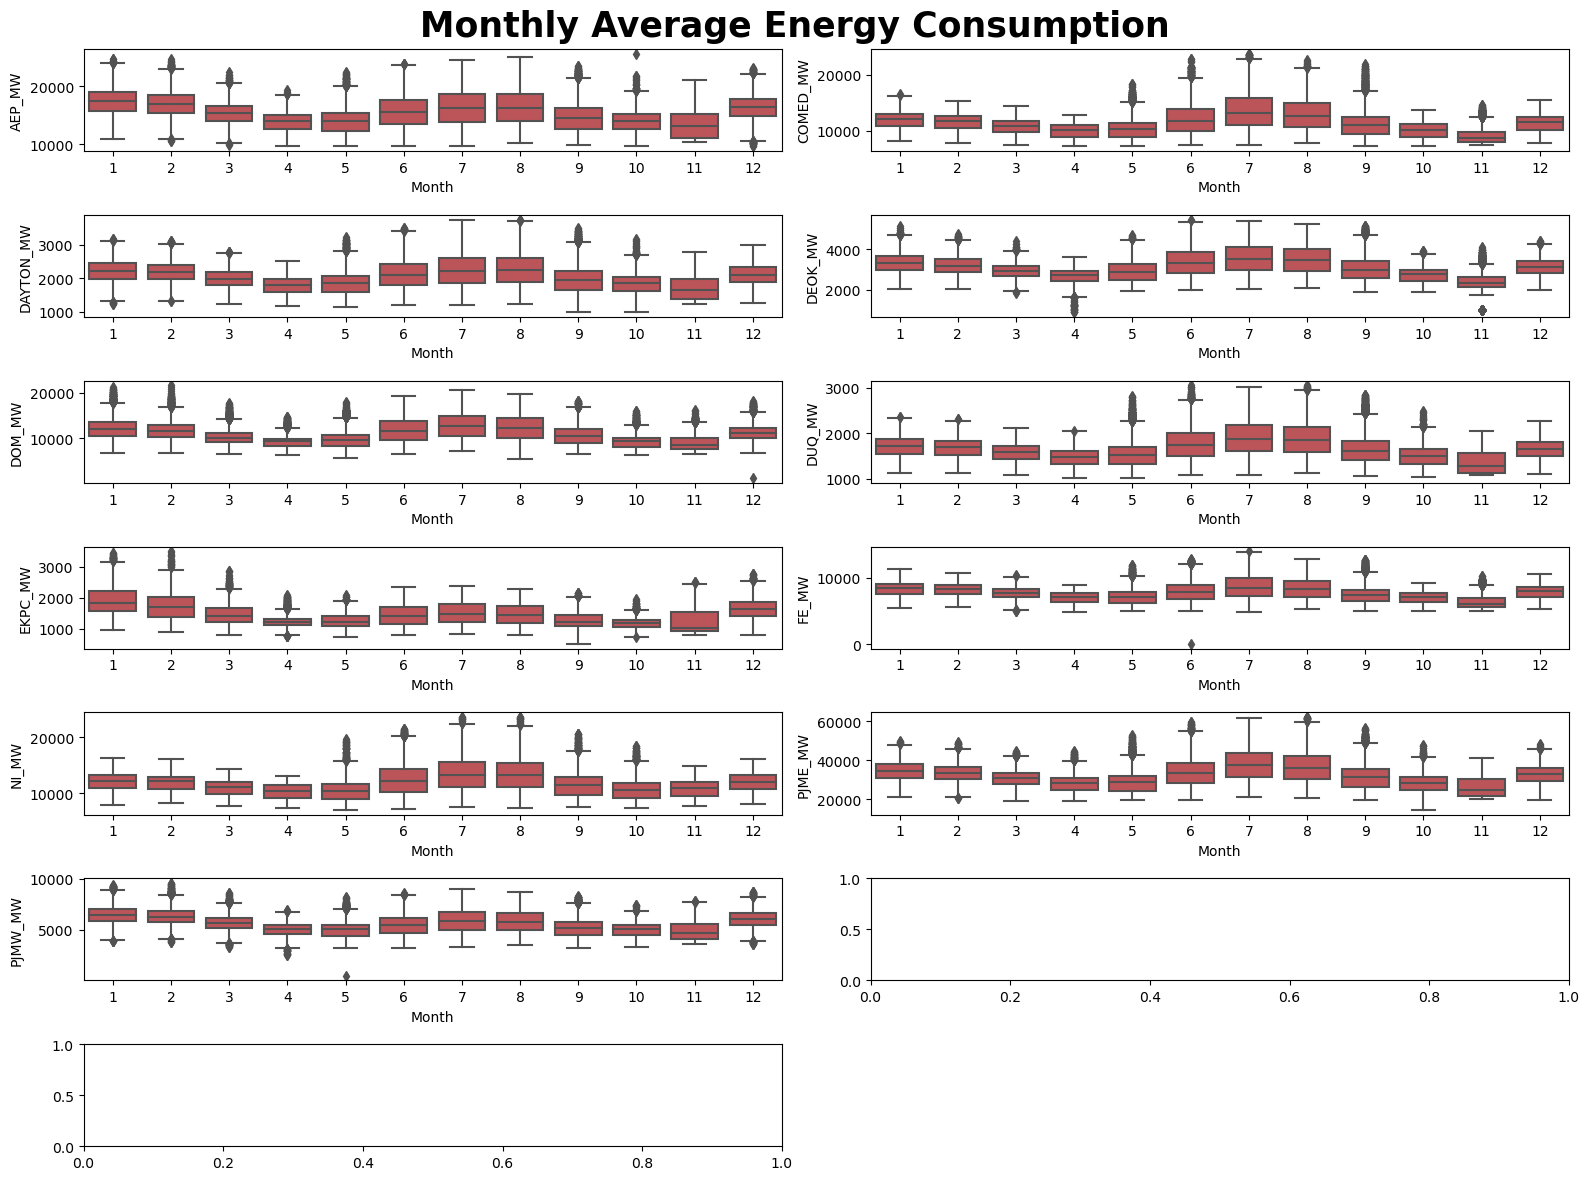

In [101]:
#Monthly Average Energy COnsumption

def visualize_subplots_boxplots(df: DataFrame, columns: List[str], nrows: int, ncols: int) -> None:
    """
    Creates a grid of subplots containing boxplots of Monthly average energy consumption.

    Args:
        df: A Pandas DataFrame containing energy consumption data.
        columns: A list of column names to include in the boxplots.
        nrows: The number of rows in the subplot grid.
        ncols: The number of columns in the subplot grid.

    Returns:
        None. Displays a grid of subplots containing boxplots of daily average energy consumption.

    Example:
        >>> visualize_subplots_boxplots(my_df, ['Consumption', 'Generation'], 3, 4)
    """
    from typing import List
    from pandas import DataFrame
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))
    fig.suptitle('Monthly Average Energy Consumption', weight='bold', fontsize=25)

    # We just need 11 figures, so we delete the last one
    if nrows*ncols > len(columns):
        fig.delaxes(axes[nrows-1][ncols-1])

    for i, col in enumerate(columns): 
        sns.boxplot(data=df, x='Month', y=col, ax=axes.flatten()[i], color='#cc444b')

    plt.tight_layout()
    fig.savefig("Images/Monthly_Average_Energy_Consumption.png", dpi=300, bbox_inches='tight')
    plt.show()
visualize_subplots_boxplots(df=result_2, columns=cols, nrows=7, ncols=2)


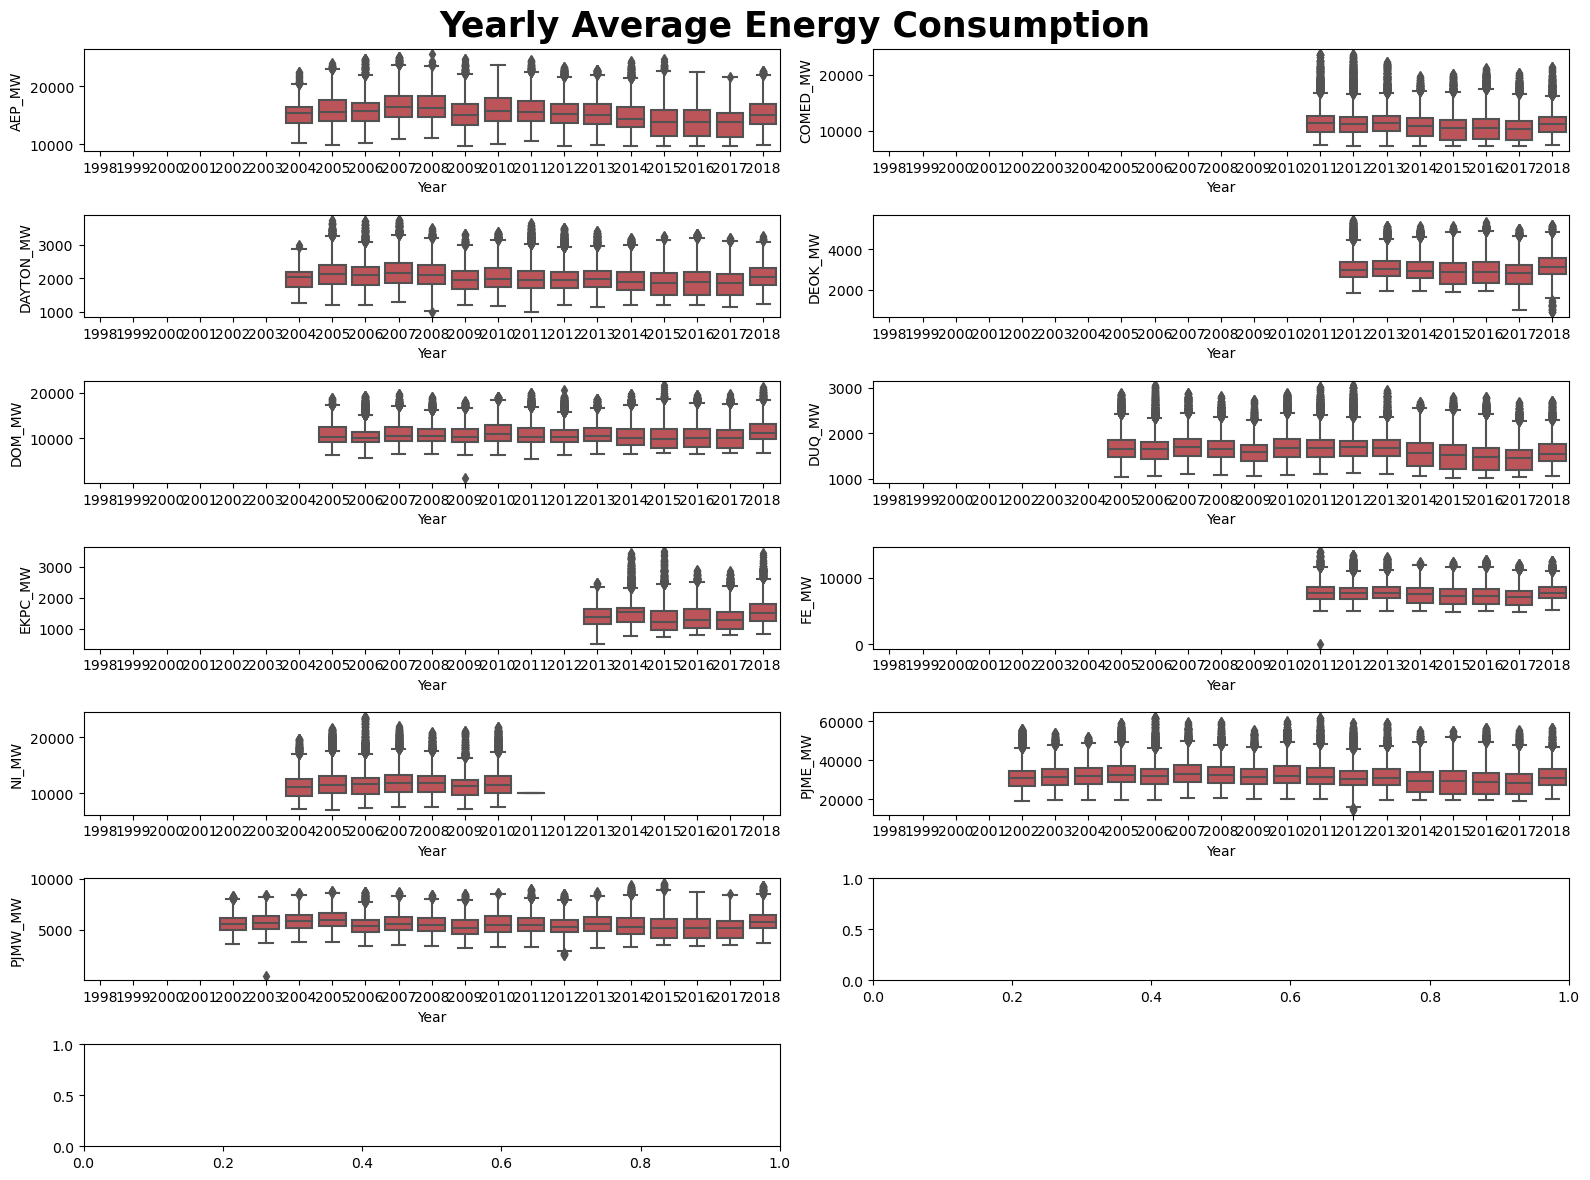

In [102]:
#Yearly Average Energy Consumption

def visualize_subplots_boxplots(df: DataFrame, columns: List[str], nrows: int, ncols: int) -> None:
    """
    Creates a grid of subplots containing boxplots of Yearly average energy consumption.

    Args:
        df: A Pandas DataFrame containing energy consumption data.
        columns: A list of column names to include in the boxplots.
        nrows: The number of rows in the subplot grid.
        ncols: The number of columns in the subplot grid.

    Returns:
        None. Displays a grid of subplots containing boxplots of daily average energy consumption.

    Example:
        >>> visualize_subplots_boxplots(my_df, ['Consumption', 'Generation'], 3, 4)
    """
    from typing import List
    from pandas import DataFrame
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))
    fig.suptitle('Yearly Average Energy Consumption', weight='bold', fontsize=25)

    # We just need 11 figures, so we delete the last one
    if nrows*ncols > len(columns):
        fig.delaxes(axes[nrows-1][ncols-1])

    for i, col in enumerate(columns): 
        sns.boxplot(data=df, x='Year', y=col, ax=axes.flatten()[i], color='#cc444b')

    plt.tight_layout() 
    fig.savefig("Images/Yearly_Average_Energy_Consumption.png", dpi=300, bbox_inches='tight')
    plt.show()
visualize_subplots_boxplots(df=result_2, columns=cols, nrows=7, ncols=2)


> Findings/Insights from the chart above:
1. The data exhibits seasonality, which is why most visualizations are similar for all columns, except for the year. Some of the data has missing values for certain years
2. PJME exhibits the highest energy consumption compared to other sources.
3. The daily peak for energy consumption occurs around 6-8 PM, while the minimum is at 2 AM.
4. The highest energy consumption in a year is typically either in the middle or end of the year.
5. Out of the 13 datasets, 5 of them do not span the full range of 2004-2018.


>> Using the Energy Consumption Data from DAYTON_MW as a Case Study to make Predictions

In [103]:
# Set color style
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['#cc444b', '#e89005'])

In [104]:
dayton = dayton.sort_index()
dayton.head(4) 

,DAYTON_MW
Datetime,
2004-10-01 01:00:00,1621.0
2004-10-01 02:00:00,1536.0
2004-10-01 03:00:00,1500.0
2004-10-01 04:00:00,1434.0


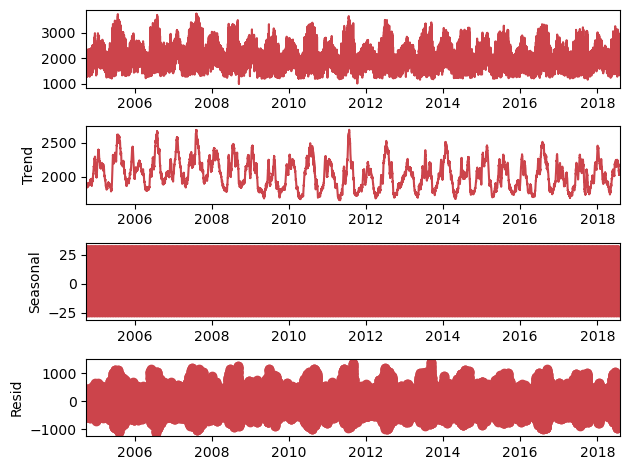

In [105]:
seasonal_decompose(dayton, period=365).plot()
plt.show()

## Moving Average

Moving average plots are a useful tool in time series analysis to better understand trends and patterns in data. A moving average is a calculation that takes the average of a subset of data points within a larger data set, typically over a fixed window size. They generally give us information of the trends in the data, the seasonality, outliers and volatility.

In [106]:
# Daily Consumption
moving_avg = dayton.resample('D').mean()

# 3 Day Example
# moving_avg['Moving Average'] = moving_avg['PJME_MW'].rolling(3).mean() 
moving_avg.head()

,DAYTON_MW
Datetime,
2004-10-01,1924.130435
2004-10-02,1641.583333
2004-10-03,1528.708333
2004-10-04,1926.541667
2004-10-05,1970.125000


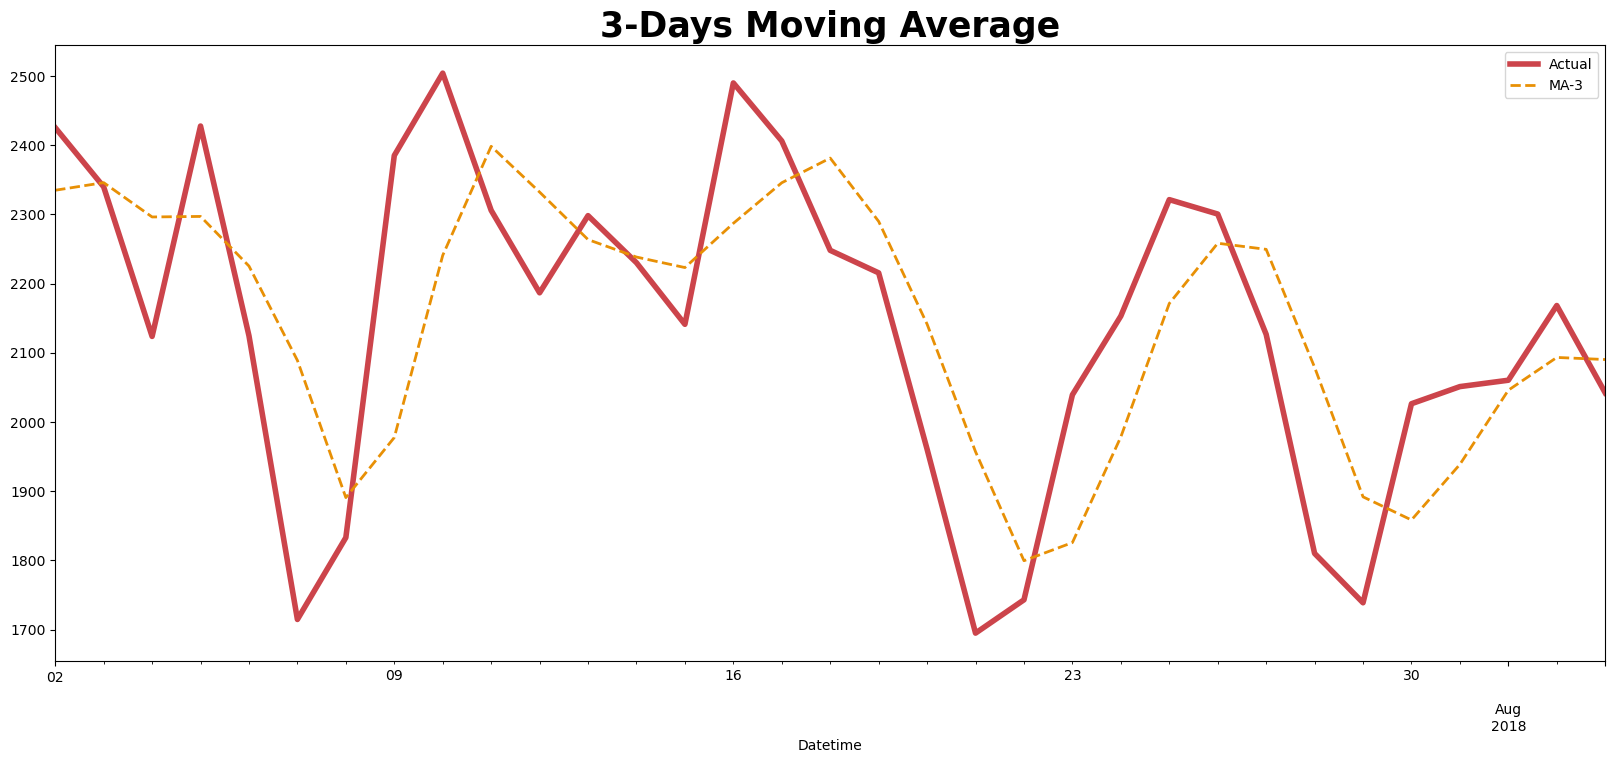

In [107]:
# Daily Consumption

def moving_average(data: pd.DataFrame, window: int, savepath) -> None:
    """
    Calculates and visualizes the moving average of a time series data.

    Args:
        data: A Pandas DataFrame containing the time series data.
        window: An integer representing the window size for calculating the moving average.

    Returns:
        None. Visualizes the actual data and the moving average.

    Example:
        >>> moving_average(my_data, 5)
    """
    # calculate the moving average
    data['Moving Average'] = data['DAYTON_MW'].rolling(window).mean()
    actual = data['DAYTON_MW'][-(window+30):]
    ma = data['Moving Average'][-(window+30):]

    # plot the actual data and moving average
    plt.figure(figsize=(20,8))
    actual.plot(label='Actual', lw=4)
    ma.plot(label='MA-{}'.format(str(window)), ls='--', lw=2)
    plt.title('{}-Days Moving Average'.format(str(window)), weight='bold', fontsize=25)
    plt.legend()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()

moving_average(moving_avg, window = 3, savepath = "Images/3_days_moving_average.png")

We can make some general assumptions about the plot above:

1. Actual Plot:
The 'actual' variable contains the actual time series data from the 'PJME_MW' column of the DataFrame, for the last 'window+30' number of data points. Depending on the characteristics of the data, the plot of 'actual' may show fluctuations, trends, seasonality, or other patterns that are common in time series data.

2. Moving Average (MA) Plot:
The 'ma' variable contains the moving average data from the 'Moving Average' column of the DataFrame, for the same time period as 'actual'. The moving average smooths out the fluctuations in the data and shows the underlying trend. The MA plot will be smoother than the actual plot, and will show the overall direction of the data more clearly.

From the chart above, we can see that both the actual plots and moving average plots make a lot of noise or flunctuations for Aug. 2018. There was a sharp drop in energy consumption around Aug 8 and Aug 20. 

The next plot is a 30-day moving average.

In [108]:
moving_avg.head(4)

,DAYTON_MW,Moving Average
Datetime,,
2004-10-01,1924.130435,NaN
2004-10-02,1641.583333,NaN
2004-10-03,1528.708333,1698.140700
2004-10-04,1926.541667,1698.944444


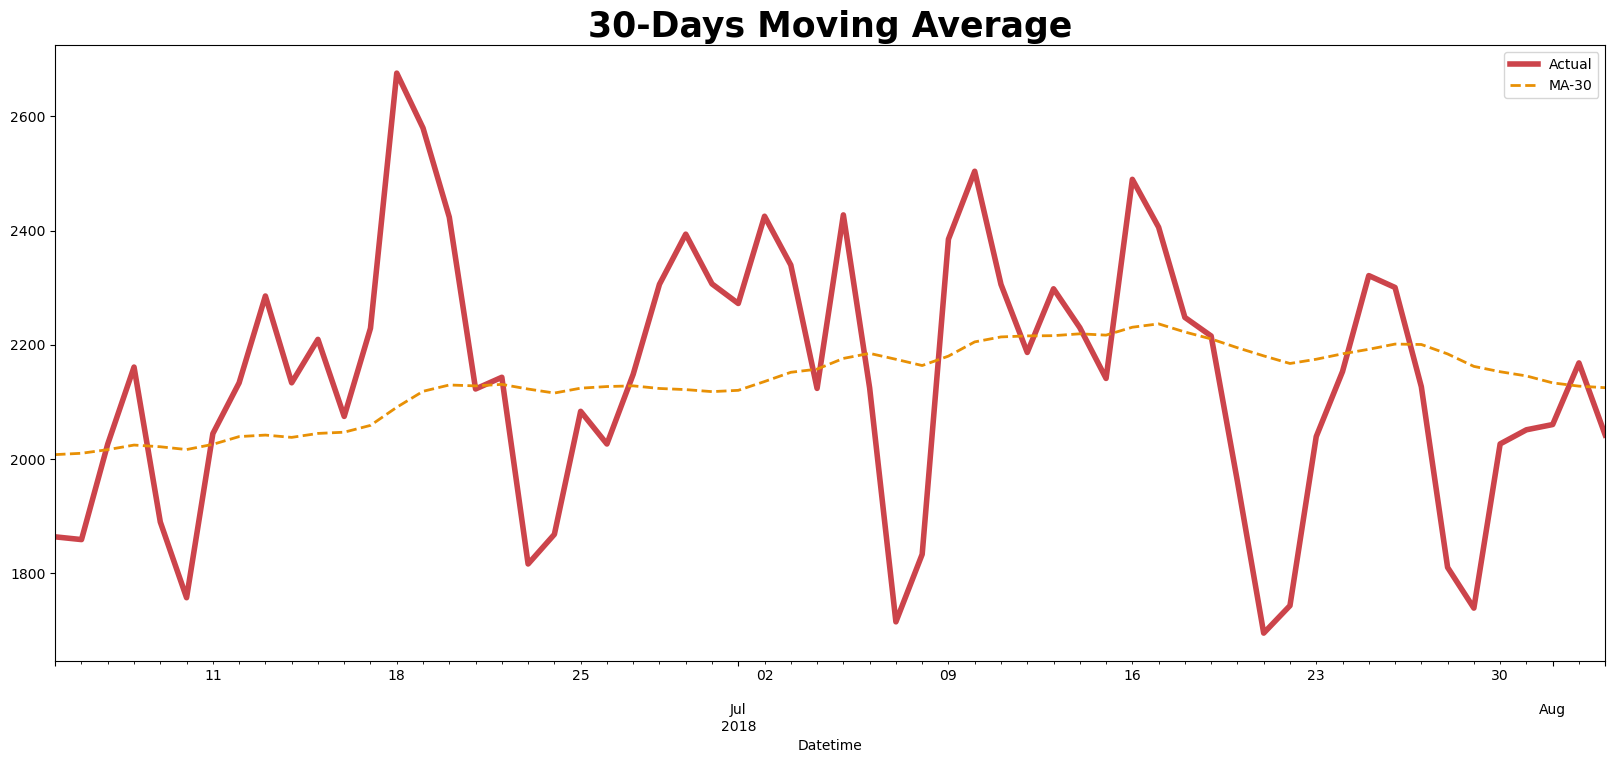

In [109]:
moving_average(moving_avg, 30, savepath = "Images/30_days_moving_average.png") 

From the charts above, 

## Building the Model

In [110]:
#splting the time-series data into test and train
dayton_train, dayton_test = dayton[dayton.index < '2015-09-01'], dayton[dayton.index >= '2015-09-01']
print('Train:\t', len(dayton_train)) 
print('Test:\t', len(dayton_test))
print(f' dayton_test is {round(((len(dayton_test)) / len(dayton_train))*100)}% of dayton_train') 


Train:	 95666
Test:	 25609
 dayton_test is 27% of dayton_train


In [111]:
dayton_test 

,DAYTON_MW
Datetime,
2015-09-01 00:00:00,2162.0
2015-09-01 01:00:00,2005.0
2015-09-01 02:00:00,1882.0
2015-09-01 03:00:00,1789.0
2015-09-01 04:00:00,1736.0
...,...
2018-08-02 20:00:00,2554.0
2018-08-02 21:00:00,2481.0
2018-08-02 22:00:00,2405.0


In [112]:
# pjme_train["use_Datetime"] = pjme_train.index.astype(float)#.sort_values(ascending=True) 
# pjme_test["use_Datetime"] = pjme_test.index.astype(float)#.sort_values(ascending=True)  

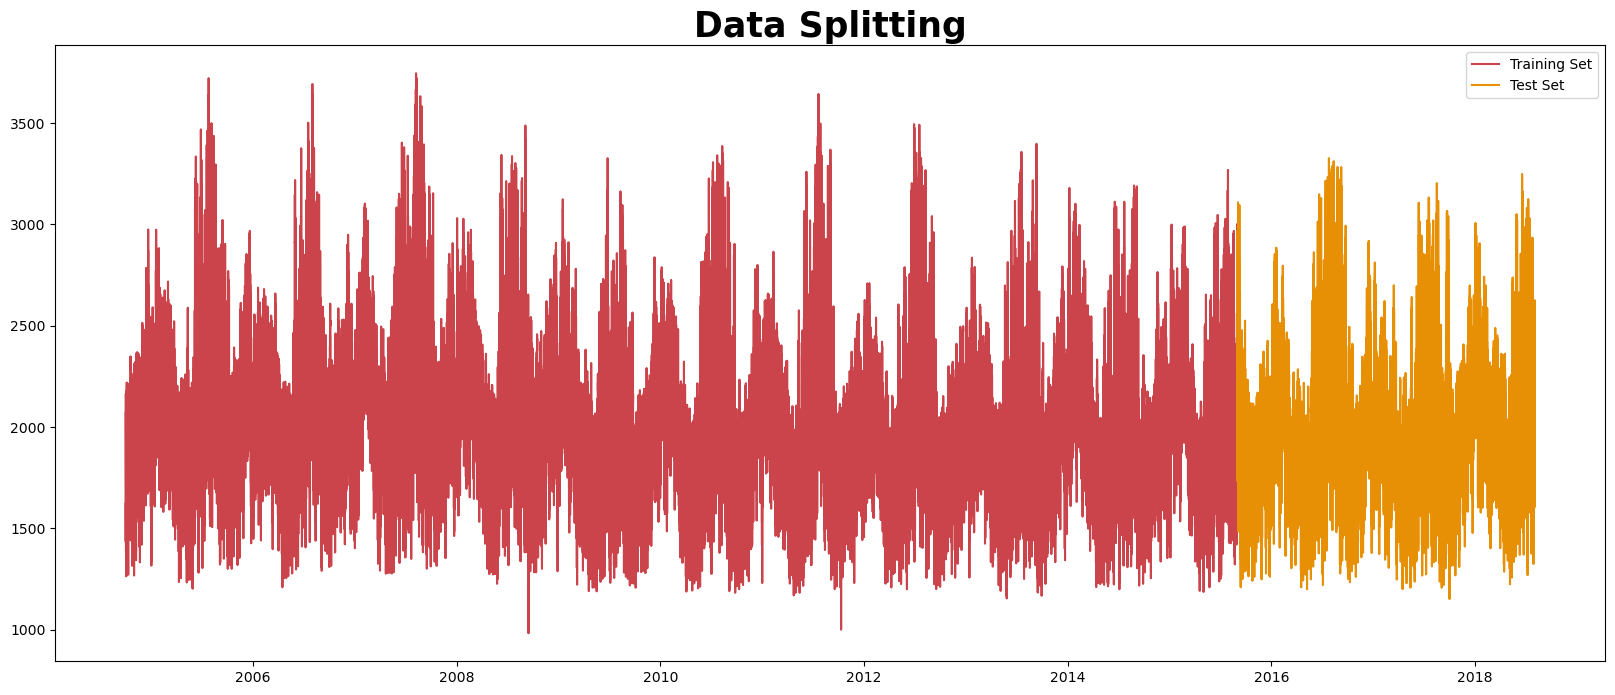

In [113]:
#visualizing how the data will be split into test and train

# plt.figure(figsize=(20,8))
# pjme_train['PJME_MW'].plot(label='Training Set')
# pjme_test['PJME_MW'].plot(label='Test Set')
# # plt.axvline('2015-09-01 00:00:00', color='black', ls='--', lw=3)
# plt.text('2015-10-01', 3700, 'Split', fontsize=20, fontweight='bold') 
# plt.title('Data Splitting', weight='bold', fontsize=25)
# # plt.text('2015-10-01', 3700, 'Split', fontsize=20, fontweight='bold')
# plt.legend()


def plot_data_splitting(train, test):
    """
    Plots the training and test sets of a time series.

    Args:
    train (pandas.DataFrame): DataFrame containing the training set with a DatetimeIndex and a 'DAYTON_MW' column.
    test (pandas.DataFrame): DataFrame containing the test set with a DatetimeIndex and a 'DAYTON_MW' column.

    Returns:
    None
    """
    plt.figure(figsize=(20,8))

    plt.plot(train.index, train['DAYTON_MW'], label='Training Set')
    plt.plot(test.index, test['DAYTON_MW'], label='Test Set')
    # plt.text('2015-10-01', 3700, 'Split', fontsize=20, fontweight='bold') 

    plt.title('Data Splitting', weight='bold', fontsize=25)
    plt.legend()
    plt.show()

plot_data_splitting(dayton_train, dayton_test) 

In [114]:
def index_to_column(data):
    data = data.reset_index()
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data = data.sort_values('Datetime')
    
    data = data.rename(columns={'Datetime': 'ds', 'DAYTON_MW': 'y'})
    return data

prophet_train = index_to_column(dayton_train)
prophet_test = index_to_column(dayton_test)  

In [115]:
prophet_test.head(3)

,ds,y
0,2015-09-01 00:00:00,2162.0
1,2015-09-01 01:00:00,2005.0
2,2015-09-01 02:00:00,1882.0


In [116]:
#Prophet Model 
prophet_model = Prophet(interval_width=0.95)

prophet_model.fit(prophet_train) 
prophet_pred = prophet_model.predict(prophet_test[['ds']]) # Keep the dataset format

# Save the model to a file
with open('models/prophet_model.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)

12:50:26 - cmdstanpy - INFO - Chain [1] start processing
12:52:33 - cmdstanpy - INFO - Chain [1] done processing


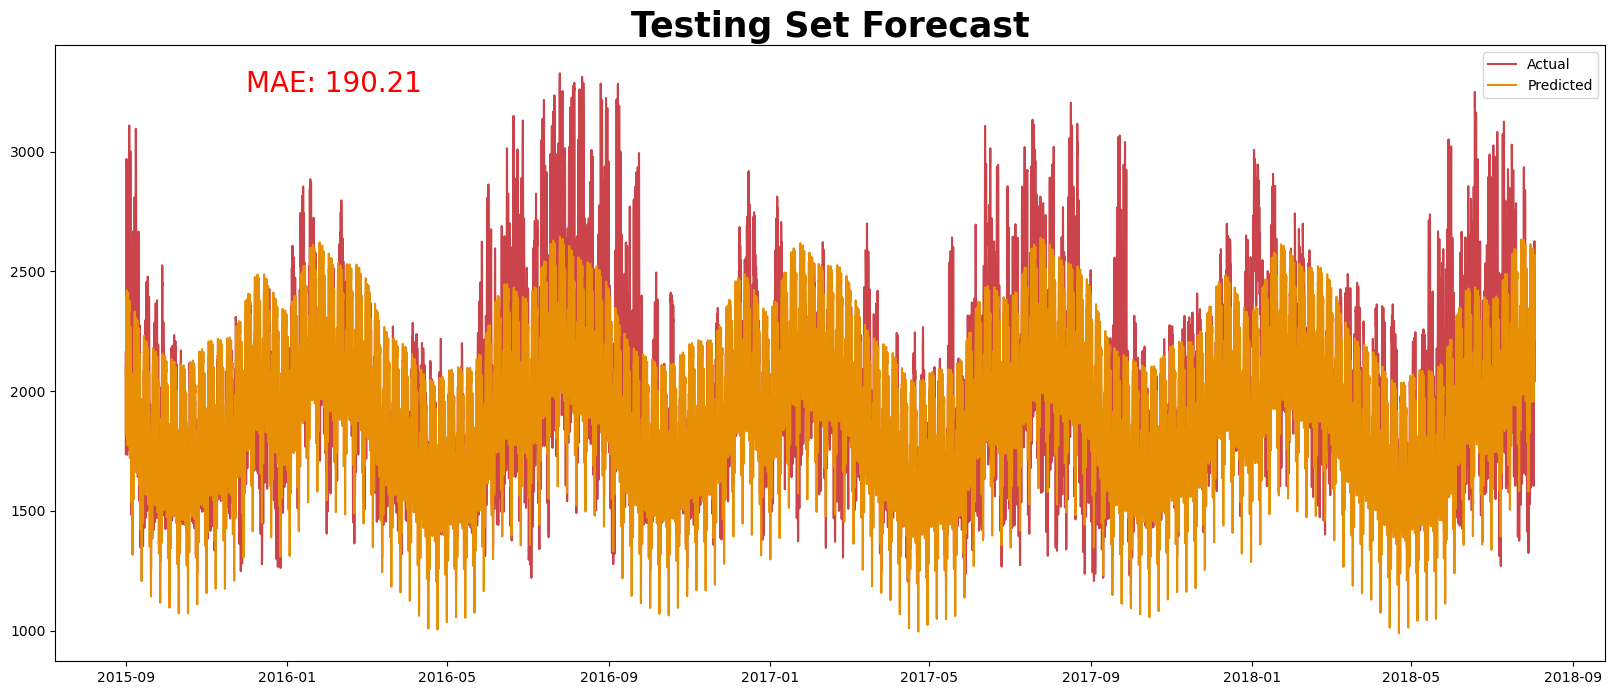

In [117]:
# mae = round(mean_absolute_error(prophet_test['y'], prophet_pred['yhat']), 3)

# plt.figure(figsize=(20,8))
# plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
# plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted')
# plt.title('Test Forecasting', weight='bold', fontsize=40)
# plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
# plt.title('Testing Set Forecast', weight='bold', fontsize=25)
# plt.legend() 

def plot_prophet_forecast(prophet_test, prophet_pred, savepath):
    """
    Plots the actual and predicted values of a Prophet test set, along with the mean absolute error (MAE).

    Parameters:
    prophet_test (pandas.DataFrame): The Prophet test set containing columns 'ds' and 'y'.
    prophet_pred (pandas.DataFrame): The Prophet predictions containing columns 'ds' and 'yhat'.

    Returns:
    None
    """
    mae = round(mean_absolute_error(prophet_test['y'], prophet_pred['yhat']), 3)
    plt.figure(figsize=(20,8))
    plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
    plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted')
    plt.title('Test Forecasting', weight='bold', fontsize=40)
    plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
    plt.title('Testing Set Forecast', weight='bold', fontsize=25)
    plt.savefig(savepath,  dpi=300, bbox_inches='tight')
    plt.legend()

plot_prophet_forecast(prophet_test, prophet_pred, savepath = "Images/testing_set_forecast.png") 

### Predicting Hourly Energy Consumption for the next 30 days

In [118]:
#Predicting Hourly Energy COnsumption for the next 30 days

# This time, we will use all data (train and test) to train our model
new_data = index_to_column(dayton) 

prophet_model2 = Prophet(interval_width=0.95)
prophet_model2.fit(new_data) 

# 30 days to the future (30x24hrs = 720hrs) 
future_dates = prophet_model2.make_future_dataframe(periods=720, freq='H')
prophet_pred2 = prophet_model2.predict(future_dates) 

# Save the model to a file
with open('models/prophet_model2.pkl', 'wb') as m:
    pickle.dump(prophet_model2, m) 

12:53:09 - cmdstanpy - INFO - Chain [1] start processing
12:55:56 - cmdstanpy - INFO - Chain [1] done processing


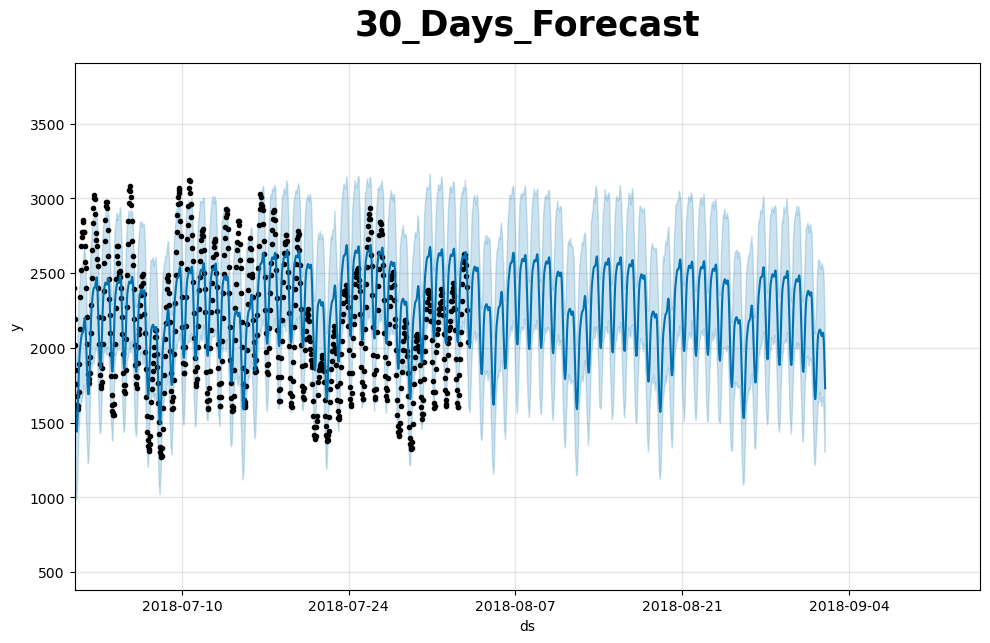

In [119]:
def plot_prophet_forecast_2(model, forecast, duration, title):
    """
    Plots a Prophet forecast.

    Parameters:
    model (Prophet): The trained Prophet model.
    forecast (pandas.DataFrame): The forecast generated by the Prophet model.

    Returns:
    None
    """
    fig = model.plot(forecast, uncertainty=True)
    ax = fig.gca()
    ax.set_xlim(pd.to_datetime(duration))
    plt.title(title, weight='bold', fontsize=25, loc= "center", pad=20)
    plt.show()
    fig.savefig(f"Images/{title}.png", dpi=300, bbox_inches='tight') 

plot_prophet_forecast_2(prophet_model2, prophet_pred2, duration = ['2018-07-01', '2018-09-15'], title='30_Days_Forecast') 

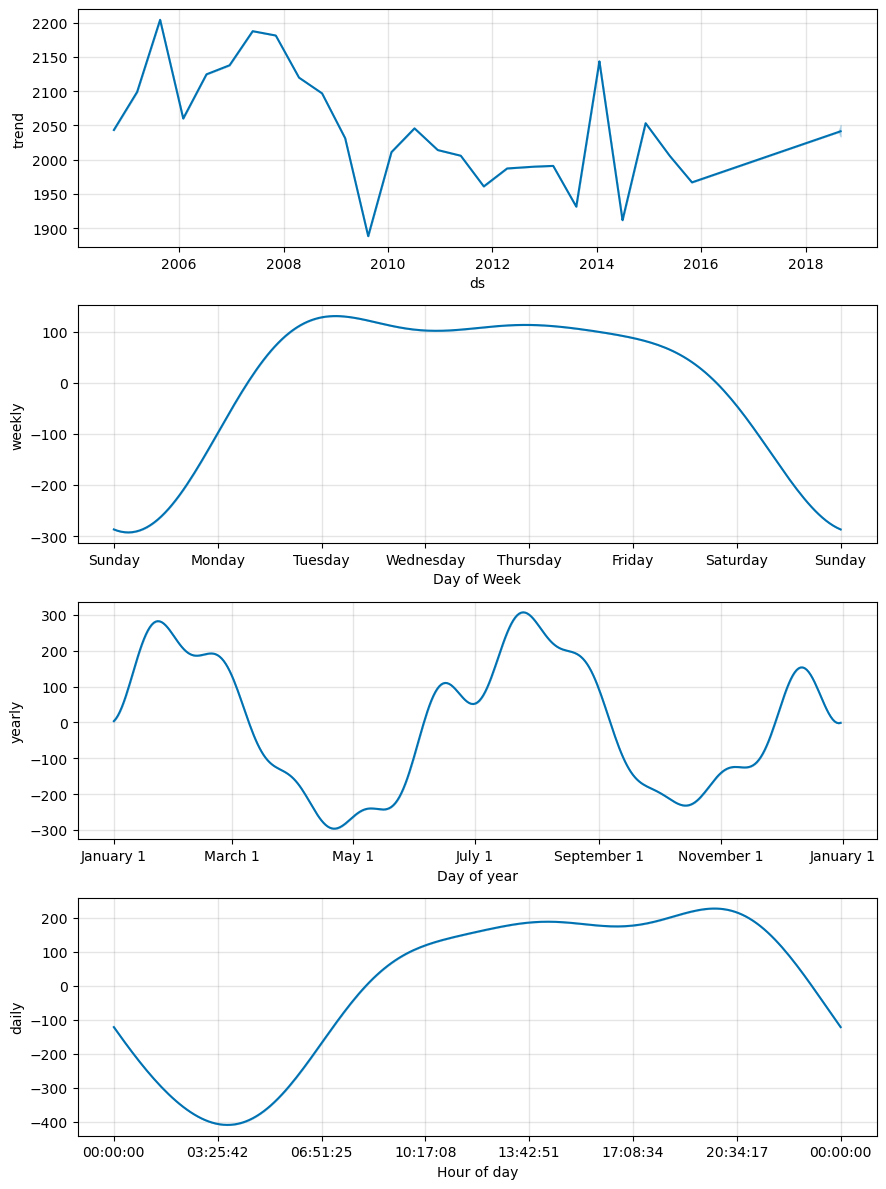

In [120]:
prophet_model.plot_components(prophet_pred2)
plt.show()

In [121]:
#predicting 15 days

#this has already been done. 
# prophet_model2 = Prophet(interval_width=0.95)
# prophet_model2.fit(new_df) 

# 15 days to the future (15x24hrs = 360hrs)
future_dates2 = prophet_model2.make_future_dataframe(periods=360, freq='H')
prophet_pred3 = prophet_model2.predict(future_dates2)


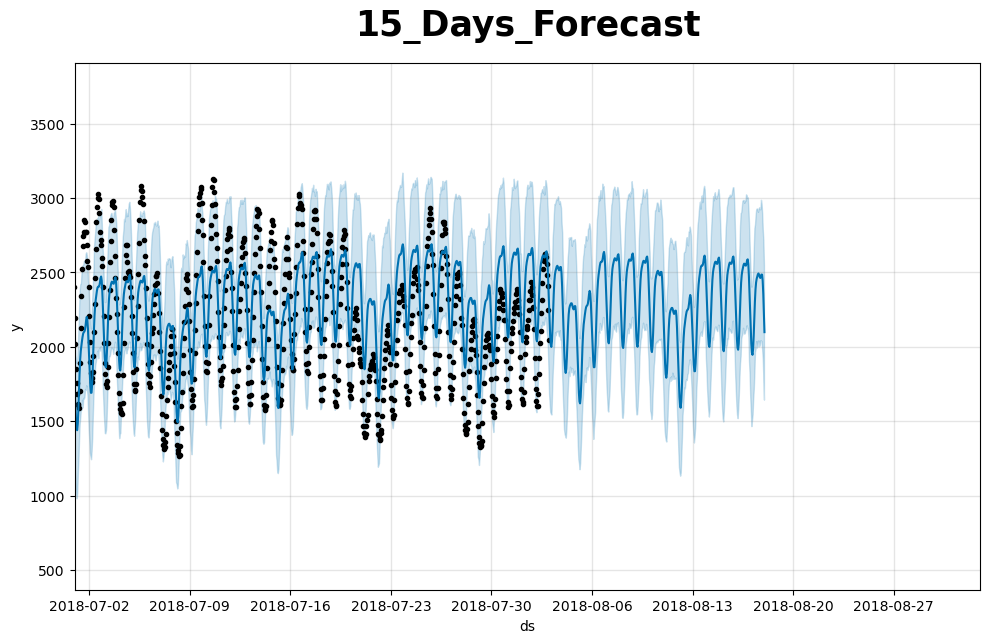

In [122]:
plot_prophet_forecast_2(prophet_model2, prophet_pred3, duration = ['2018-07-01', '2018-09-02'], title='15_Days_Forecast') 


### Evaluation Metrics for Time Series Analaysis using Prophet

Some of the commonly used evaluation metrics for Prophet time series analysis include:

1. Mean Absolute Error (MAE): This metric measures the average absolute difference between the actual and predicted values of the target variable. A lower MAE value indicates better model performance.

2. Mean Squared Error (MSE): This metric measures the average squared difference between the actual and predicted values of the target variable. A lower MSE value indicates better model performance.

3. Root Mean Squared Error (RMSE): This metric is the square root of the MSE and measures the average difference between the actual and predicted values of the target variable. A lower RMSE value indicates better model performance.

4. Mean Absolute Percentage Error (MAPE): This metric measures the average percentage difference between the actual and predicted values of the target variable. A lower MAPE value indicates better model performance.

5. Symmetric Mean Absolute Percentage Error (SMAPE): This metric measures the average percentage difference between the actual and predicted values of the target variable, taking into account the scale of the variable. A lower SMAPE value indicates better model performance.

6. Coverage: This metric measures the proportion of actual values that fall within the forecasted intervals. A higher coverage value indicates better model performance.

7. Quantile loss: This metric measures the deviation between the actual values and the quantile forecasted values. A lower quantile loss indicates better model performance.

In [123]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_prophet_model(model, test_set):
    """
    Evaluate a Prophet model using mean absolute error (MAE), root mean squared error (RMSE), and mean absolute percentage error (MAPE).
    
    Parameters:
    -----------
    model : Prophet object
        Fitted Prophet model
    test_set : DataFrame
        DataFrame containing the test set with columns 'ds' and 'y'
        
    Returns:
    --------
    mae : float
        Mean absolute error
    rmse : float
        Root mean squared error
    mape : float
        Mean absolute percentage error
    """
    
    # Make predictions on test set
    forecast = model.predict(test_set)
    y_true = test_set['y'].values
    y_pred = forecast['yhat'].values
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return mae, rmse, mape




In [124]:
mae, rmse, mape = evaluate_prophet_model(prophet_model, prophet_test)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape) 

MAE: 190.20998749257706
RMSE: 249.15828923385155
MAPE: 9.425281265352044


1. MAE (Mean Absolute Error): The value of 190.20998749257706 means that, on average, the predictions made by the model are off by 190.21 units of the same scale as the original data. For example, if the time series is in dollars, then the average prediction error is $190.21.

2. RMSE (Root Mean Square Error): The value of 249.15828923385155 represents the square root of the average of the squared differences between the predicted and actual values. RMSE is a measure of the overall magnitude of the errors, and its value is in the same scale as the original data.

3. MAPE (Mean Absolute Percentage Error): The value of 9.425281265352044 means that, on average, the model's predictions are off by 9.43% of the actual value. MAPE is a relative measure of the prediction accuracy and is expressed as a percentage.

Overall, a lower value of MAE, RMSE, and MAPE indicates better prediction accuracy of the model. However, the interpretation of what is considered "good" values for these metrics may vary depending on the specific context and application of the time series model.

In [125]:
# To fine tune the Prophet model in order to improve the performance, you can experiment with the following:

# 1. Changing the hyperparameters such as changepoint_prior_scale, seasonality_prior_scale, 
        # and holidays_prior_scale to see if they improve the model's performance.
# 2. Adding or removing holidays or events that may impact the time series data.
# 3. Adjusting the interval_width to get wider or narrower prediction intervals.
# 4. Adding or removing regressors that may have an impact on the time series data.
# 5. Increasing the training data period or adjusting the time period for the testing data.
# 6. Changing the frequency of the time series data to capture seasonality more accurately.
# 7. Trying different models such as ARIMA, SARIMA, or LSTM to see if they provide better results.